In [582]:
import matplotlib.pyplot as plt
import numpy as np
from pymongo import MongoClient
import copy
import math
from enum import Enum
import pprint

class CollectibleType(Enum):
  All = 1
  Hands = 2
  Feet = 3
  Left = 4
  Right = 5
  LeftHand = 6
  RightHand = 7
  LeftFoot = 8
  RightFoot = 9

client = MongoClient('localhost', 27017)

db = client['beatfork']

versions = db.versions.find()

def calcDistanceXY(posA, posB):
  return ( (posA['x'] - posB['x']) ** 2 + (posA['y'] - posB['y']) ** 2 ) ** (1 / 2)

def calcDistanceZ(posA, posB):
  return abs(posA['z'] - posB['z'])

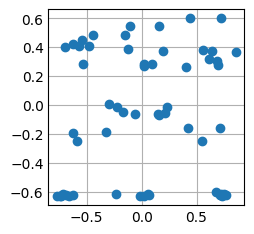

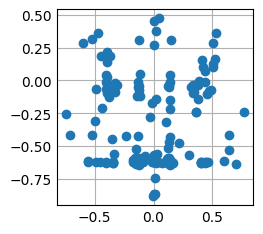

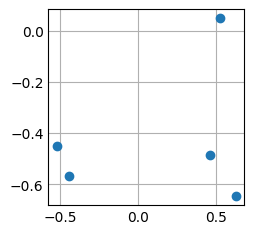

In [583]:
def plotXYOccurence(version):
  plt.style.use('_mpl-gallery')

  x = np.array(list(map(lambda obj:
    obj['position']['x']
  , version['objects'])))
  y = np.array(list(map(lambda obj:
    obj['position']['y']
  , version['objects'])))

  fig, ax = plt.subplots()

  ax.scatter(x, y, vmin=-1, vmax=1)

  plt.show()

for version in copy.deepcopy(versions):
  plotXYOccurence(version)

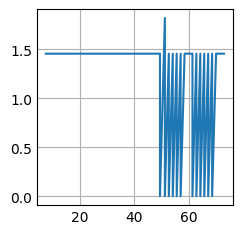

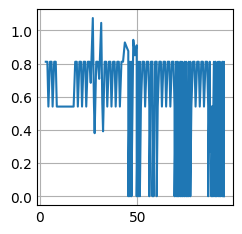

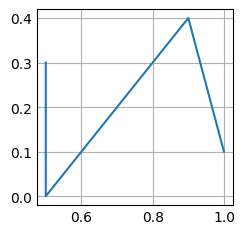

In [584]:
def plotZDistance(version):
  plt.style.use('_mpl-gallery')

  zDistanceBetweenBlocks = []
  lastZ = version['objects'].pop(0)['position']['z']
  for obj in version['objects']:
    zDistanceBetweenBlocks.append(obj['position']['z'] - lastZ)
    lastZ = obj['position']['z']

  x = np.array(list(map(lambda obj:
    obj['position']['z']
  , version['objects'])))
  y = np.array(zDistanceBetweenBlocks)

  fig, ax = plt.subplots()

  ax.plot(x, y)

  plt.show()

for version in copy.deepcopy(versions):
  plotZDistance(version)

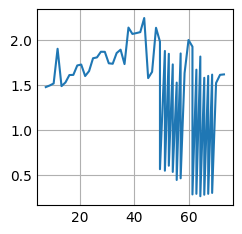

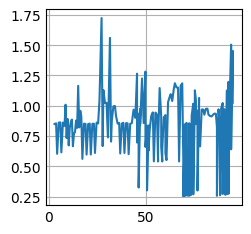

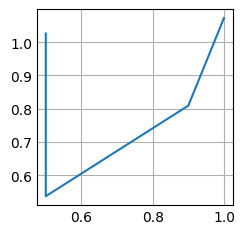

In [585]:
def plotDistance(version):
  plt.style.use('_mpl-gallery')

  distanceBetweenBlocks = []
  lastPosition = version['objects'].pop(0)['position']
  for obj in version['objects']:
    distanceBetweenBlocks.append((
      (obj['position']['x'] - lastPosition['x']) ** 2 +
      (obj['position']['y'] - lastPosition['y']) ** 2 +
      (obj['position']['z'] - lastPosition['z']) ** 2 ) ** 0.5)
    lastPosition = obj['position']

  x = np.array(list(map(lambda obj:
    obj['position']['z']
  , version['objects'])))
  y = np.array(distanceBetweenBlocks)

  fig, ax = plt.subplots()

  ax.plot(x, y)

  plt.show()

for version in copy.deepcopy(versions):
  plotDistance(version)

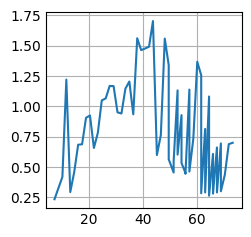

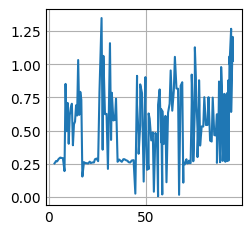

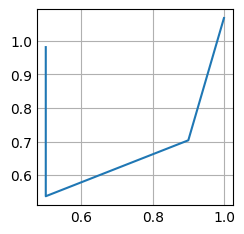

In [586]:
def plotXYDistance(version):
  plt.style.use('_mpl-gallery')

  distanceBetweenBlocks = []
  lastPosition = version['objects'].pop(0)['position']
  for obj in version['objects']:
    distanceBetweenBlocks.append((
      (obj['position']['x'] - lastPosition['x']) ** 2 +
      (obj['position']['y'] - lastPosition['y']) ** 2 ) ** 0.5)
    lastPosition = obj['position']

  x = np.array(list(map(lambda obj:
    obj['position']['z']
  , version['objects'])))
  y = np.array(distanceBetweenBlocks)

  fig, ax = plt.subplots()

  ax.plot(x, y)

  plt.show()

for version in copy.deepcopy(versions):
  plotXYDistance(version)

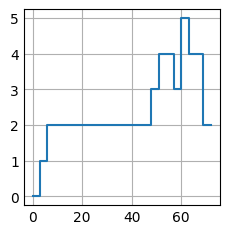

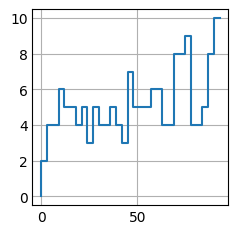

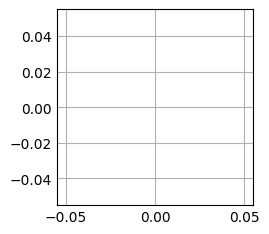

In [587]:
def plotDensity(version):
  secondsPerInterval = 3

  plt.style.use('_mpl-gallery')

  objects = version['objects']
  end = objects[-1]['position']['z']
  density = []
  for i in range(0, math.ceil(end / secondsPerInterval) * secondsPerInterval, secondsPerInterval):
    obstaclesInInterval = 0
    while len(objects) > 0 and objects[0]['position']['z'] < i:
      obstaclesInInterval += 1
      objects.pop(0)
    density.append(obstaclesInInterval)

  x = np.arange(0, math.ceil(end / secondsPerInterval) * secondsPerInterval, secondsPerInterval)
  y = np.array(density)

  fig, ax = plt.subplots()

  ax.step(x, y)

  plt.show()

for version in copy.deepcopy(versions):
  plotDensity(version)

In [588]:
def calcIntensity(distance, time):
  if (distance == 0):
    return 0
  if (time == 0):
    return math.inf
  return distance / time

def pickMinScore(options):
  minScore = math.inf
  minOption = None
  scores = list(map(lambda option:
    (
      (option['cumulatedIntensity'][CollectibleType.LeftHand.value]) +
      (option['cumulatedIntensity'][CollectibleType.RightHand.value]) +
      (option['cumulatedIntensity'][CollectibleType.LeftFoot.value]) +
      (option['cumulatedIntensity'][CollectibleType.RightFoot.value])
    )
  , options))
  for i in range(0, len(options)):
    if i == 0 or scores[i] < minScore:
      minScore = scores[i]
      minOption = options[i]
  return minOption

def pickMinSquareRootScore(options):
  minScore = math.inf
  minOption = None
  squareRoots = list(map(lambda option:
    (
      (option['cumulatedIntensity'][CollectibleType.LeftHand.value] ** 2) +
      (option['cumulatedIntensity'][CollectibleType.RightHand.value] ** 2) +
      (option['cumulatedIntensity'][CollectibleType.LeftFoot.value] ** 2) +
      (option['cumulatedIntensity'][CollectibleType.RightFoot.value] ** 2)
    ) ** (1 / 2)
  , options))
  for i in range(0, len(options)):
    if i == 0 or squareRoots[i] < minScore:
      minScore = squareRoots[i]
      minOption = options[i]
  return minOption

def getMinSquaredIntensityRec(objects, cumulatedIntensity, lastPositions):
  if len(objects) == 0:
    return {
      'cumulatedIntensity': cumulatedIntensity
    }
  obj = objects.pop(0)
  if obj['type'] == 'Collectible':
    match obj['collectibleType']:
      case CollectibleType.All.value:
        obj['collectibleType'] = CollectibleType.LeftHand.value
        a = getMinSquaredIntensityRec([obj, *objects], copy.deepcopy(cumulatedIntensity), copy.deepcopy(lastPositions))
        obj['collectibleType'] = CollectibleType.RightHand.value
        b = getMinSquaredIntensityRec([obj, *objects], copy.deepcopy(cumulatedIntensity), copy.deepcopy(lastPositions))
        obj['collectibleType'] = CollectibleType.LeftFoot.value
        c = getMinSquaredIntensityRec([obj, *objects], copy.deepcopy(cumulatedIntensity), copy.deepcopy(lastPositions))
        obj['collectibleType'] = CollectibleType.RightFoot.value
        d = getMinSquaredIntensityRec([obj, *objects], copy.deepcopy(cumulatedIntensity), copy.deepcopy(lastPositions))
        return pickMinScore([a, b, c, d])
      case CollectibleType.Hands.value:
        obj['collectibleType'] = CollectibleType.LeftHand.value
        a = getMinSquaredIntensityRec([obj, *objects], copy.deepcopy(cumulatedIntensity), copy.deepcopy(lastPositions))
        obj['collectibleType'] = CollectibleType.RightHand.value
        b = getMinSquaredIntensityRec([obj, *objects], copy.deepcopy(cumulatedIntensity), copy.deepcopy(lastPositions))
        return pickMinScore([a, b])
      case CollectibleType.Feet.value:
        obj['collectibleType'] = CollectibleType.LeftFoot.value
        a = getMinSquaredIntensityRec([obj, *objects], copy.deepcopy(cumulatedIntensity), copy.deepcopy(lastPositions))
        obj['collectibleType'] = CollectibleType.RightFoot.value
        b = getMinSquaredIntensityRec([obj, *objects], copy.deepcopy(cumulatedIntensity), copy.deepcopy(lastPositions))
        return pickMinScore([a, b])
      case CollectibleType.Left.value:
        obj['collectibleType'] = CollectibleType.LeftHand.value
        a = getMinSquaredIntensityRec([obj, *objects], copy.deepcopy(cumulatedIntensity), copy.deepcopy(lastPositions))
        obj['collectibleType'] = CollectibleType.LeftFoot.value
        b = getMinSquaredIntensityRec([obj, *objects], copy.deepcopy(cumulatedIntensity), copy.deepcopy(lastPositions))
        return pickMinScore([a, b])
      case CollectibleType.Right.value:
        obj['collectibleType'] = CollectibleType.RightHand.value
        a = getMinSquaredIntensityRec([obj, *objects], copy.deepcopy(cumulatedIntensity), copy.deepcopy(lastPositions))
        obj['collectibleType'] = CollectibleType.RightFoot.value
        b = getMinSquaredIntensityRec([obj, *objects], copy.deepcopy(cumulatedIntensity), copy.deepcopy(lastPositions))
        return pickMinScore([a, b])
      case CollectibleType.LeftHand.value | CollectibleType.RightHand.value | CollectibleType.LeftFoot.value | CollectibleType.RightFoot.value:
        distanceXY = calcDistanceXY(lastPositions[obj['collectibleType']], obj['position'])
        distanceZ = calcDistanceZ(lastPositions[obj['collectibleType']], obj['position'])
        intensity = calcIntensity(distanceXY, distanceZ)
        cumulatedIntensity[obj['collectibleType']] += intensity
        lastPositions[obj['collectibleType']] = obj['position']
        return getMinSquaredIntensityRec(copy.deepcopy(objects), copy.deepcopy(cumulatedIntensity), copy.deepcopy(lastPositions))
  else: # obstacle
    # todo
    return getMinSquaredIntensityRec(copy.deepcopy(objects), copy.deepcopy(cumulatedIntensity), copy.deepcopy(lastPositions))

# Naive algorithm is 
# * way too slow ( O(n^4) )
# * probably of low quality
#
# i = 0
# for version in copy.deepcopy(versions):
#   i += 1
#   if i != 3:
#     continue
#   pprint.pprint(getMinSquaredIntensityRec(
#     version['objects'],
#     {
#       CollectibleType.LeftHand.value: 0,
#       CollectibleType.RightHand.value: 0,
#       CollectibleType.LeftFoot.value: 0,
#       CollectibleType.RightFoot.value: 0,
#     },
#     {
#       CollectibleType.LeftHand.value: {
#         'x': -0.3,
#         'y': 0,
#         'z': 0
#       },
#       CollectibleType.RightHand.value: {
#         'x': 0.3,
#         'y': 0,
#         'z': 0
#       },
#       CollectibleType.LeftFoot.value: {
#         'x': -0.2,
#         'y': -1,
#         'z': 0
#       },
#       CollectibleType.RightFoot.value: {
#         'x': 0.2,
#         'y': -1,
#         'z': 0
#       }
#     })
#   )
#   break




{'cumulatedIntensity': {6: 2.6823831352259146,
                        7: 0.4514081570163743,
                        8: 0,
                        9: 1.7279099478856375}}
